In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# pip install matplotlib

In [ ]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pydub.silence import split_on_silence
from pydub.utils import make_chunks

#بارگذاری صدا

In [ ]:
voice = AudioSegment.from_file("/content/drive/MyDrive/voice/alireza.ogg")
voice

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


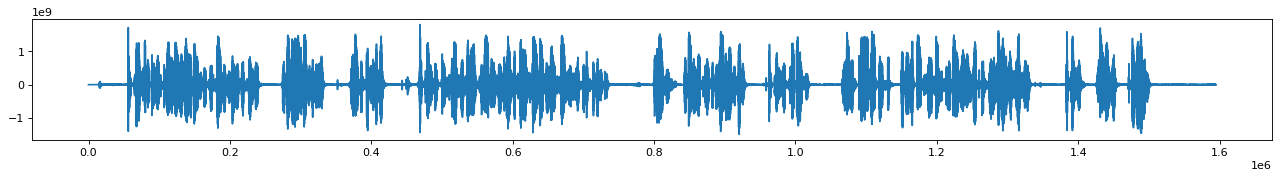

In [ ]:
array =voice.get_array_of_samples()
# samples = np.array(array)
plt.figure(figsize=(20,2), dpi=80)
plt.plot(array)
plt.show()

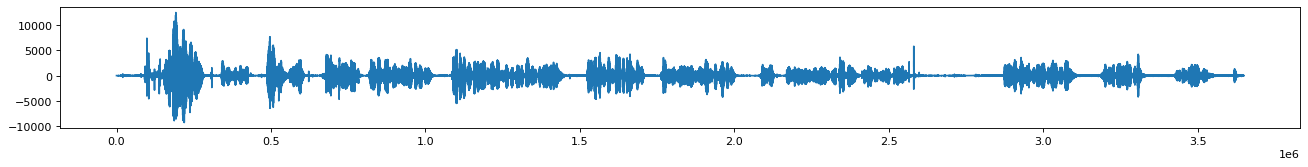

In [ ]:
voice1 = AudioSegment.from_file("/content/drive/MyDrive/voice/morteza_1.m4a")
voice2 = AudioSegment.from_file('/content/drive/MyDrive/voice/morteza_2.m4a')
result = voice1+voice2
result.export("/content/drive/MyDrive/voic_clssification/result_voice/morteza.wav", format='wav')
result
array =result.get_array_of_samples()
# samples = np.array(array)
plt.figure(figsize=(20,2), dpi=80)
plt.plot(array)
plt.show()

In [ ]:
voice1 = AudioSegment.from_file("/content/drive/MyDrive/voic_clssification/voice/mohammadali_1.ogg")
voice2 = AudioSegment.from_file('/content/drive/MyDrive/voic_clssification/voice/mohammadali_2.ogg')
result = voice1+voice2
result.export("/content/drive/MyDrive/voic_clssification/result_voice/mohammadali.wav", format='wav')
result

##جدا کردن قسمت های بی صدا از صدای مرتضی

In [ ]:
voice =AudioSegment.from_file('/content/drive/MyDrive/voic_clssification/result_voice/morteza.wav')
morteza_silence_voice =split_on_silence(voice,min_silence_len=2000, silence_thresh = -45)
morteza_silence_voice


#چسباندن بخش های صدا

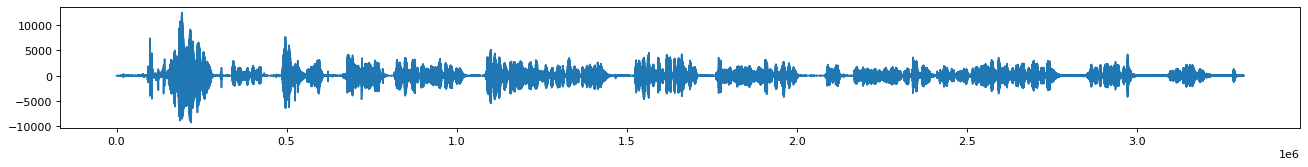

In [ ]:
# morteza_silence_voice[0]+morteza_silence_voice[1]
combined_voice=sum(morteza_silence_voice)
combined_voice
array =combined_voice.get_array_of_samples()
# samples = np.array(array)
plt.figure(figsize=(20,2), dpi=80)
plt.plot(array)
plt.show()

In [ ]:
combined_voice.export('/content/drive/MyDrive/voic_clssification/voices_silence/morteza.wav', format='wav')

<_io.BufferedRandom name='/content/drive/MyDrive/voic_clssification/voices_silence/morteza.wav'>

##تکه تکه کردن صدا ها
## برداشتن قسمت های بی صدا
## برداشتن پسوند ها
## ترکیب صدا ها با پسوند
## .wav

In [ ]:
audio_Path='/content/drive/MyDrive/voic_clssification/result_voice'
audios_remove_silence_path='/content/drive/MyDrive/voic_clssification/audio_remove_silence_part'
for file in os.listdir(audio_Path):
  file_Path=os.path.join(audio_Path,file)
  voice = AudioSegment.from_file(file_Path)
  voice_parts = split_on_silence(voice, min_silence_len=2000,silence_thresh=-45)
  combined_voice = sum(voice_parts)
  name=Path(file).stem
  output_path=os.path.join(audios_remove_silence_path, name+".wav")
  combined_voice.export(output_path, format="wav")


## برش صدا ها به تکه های یک ثانیه ای برای ایجاد دیتا ست

In [ ]:
dataset_path = '/content/drive/MyDrive/voic_clssification/dataset'
audios_remove_silence_path = '/content/drive/MyDrive/voic_clssification/audio_remove_silence_part'
for file in os.listdir(audios_remove_silence_path):
  file_Path = os.path.join(audios_remove_silence_path,file)
  voice=AudioSegment.from_file(file_Path)
  chunks = make_chunks(voice, 1000)
  name=Path(file).stem
  Path(os.path.join(dataset_path,name)).mkdir(exist_ok=True)
  for i , chunk in enumerate(chunks):
    if len(chunk)<1000:
      continue
    output_path = os.path.join(dataset_path,name,name+f"_{i}.wav")
    chunk.export(output_path, format="wav")

#طراحی شبکه

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchaudio
import numpy as np
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using:{device}")

Using:cpu


In [3]:
epochs=40
lr=0.001
batch_size=4

In [4]:
class AudioDataset(Dataset):
  def __init__(self,root):
    self.dir_path= root
    self.classes=os.listdir(self.dir_path)
    print(self.classes)
    self.data_paths = []
    self.labels = []
    for root,  dir, files in os.walk(self.dir_path):
        for file in files:
            label = os.path.basename(root)
            data_path = os.path.join(root,file)
            self.data_paths.append(data_path)
            self.labels.append(self.classes.index(label))
    print(f"{len(self.labels)} datas lebeled from{len(set(self.labels))} classes") # set remove duplicate labels
  def __len__(self):
    return len(self.labels)

  def __getitem__(self,index):
    data_path = self.data_paths[index]
    label = self.labels[index]
    signal, sample_rate = torchaudio.load(data_path)
    signal = torch.mean(signal, dim=0, keepdim=True)
    new_sample_rate = 8000
    transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
    signal = transform(signal)

    return signal, label

In [5]:
dataset = '/content/drive/MyDrive/voic_clssification/dataset'

In [6]:
dataset =AudioDataset(dataset)

['zahra', 'maryam', 'parisa', 'zeynab_1', 'benyamin', 'alireza', 'nahid', 'morteza', 'mohammadali']
460 datas lebeled from9 classes


##ایجاد دیتا ست های تست و ترین

In [7]:
train_size = int(0.8 * len(dataset)) #%80 for train
test_size = len(dataset) - train_size # %20 for test
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## طراحی مدل
##تعریف accuracy

In [24]:
from numpy.core.numeric import indices
class Model(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        return x
    def accuracy(self,preds,labels):
      maxs, indices= torch.max(preds,1)
      acc = torch.sum(indices==labels) / len(preds)
      return acc.cpu()

##پرینت خلاصه مدل و تعداد پارامتر ها

In [25]:
from torch.autograd import grad
model=Model(n_output=9).to(device)
print(model)
#count_parameters
n= sum(p.numel() for p in model.parameters() if p.requires_grad)
print("number of parameters %s" %n)

Model(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (fc1): Linear(in_features=64, out_features=9, bias=True)
)
number of parameters 25225


In [26]:
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
loss_function = nn.CrossEntropyLoss()

In [ ]:
# TRAIN
model.train()
for epoch in range(epochs):
  train_acc = 0.0
  train_loss = 0.0
  model.train()
  for audios, labels in tqdm(train_data_loader):
    labels = labels.to(device)
    audios = audios.to(device)
    labels_one_hot = torch.nn.functional.one_hot(labels,num_classes=9).type(torch.FloatTensor).to(device)
    optimizer.zero_grad()
    pred = model(audios)
    loss = loss_function(pred,labels_one_hot)
    loss.backward()
    optimizer.step()

    train_loss += loss
    train_acc += model.accuracy(pred,labels)

  total_train_loss = train_loss / len(train_data_loader)
  total_train_acc = train_acc / len(train_data_loader)
  print(f"Epochs: {epoch+1}, Accuracy: {total_train_acc}, Loss: {total_train_loss}")

In [28]:
model.eval()

test_acc = 0.0
test_loss = 0.0
for audios, labels in tqdm(test_data_loader):
    audios = audios.to(device)
    labels = labels.to(device)
    labels_one_hot = F.one_hot(labels,num_classes=9).type(torch.FloatTensor).to(device)

    pred = model(audios)
    loss = loss_function(pred,labels_one_hot)
    test_loss += loss
    test_acc += model.accuracy(pred, labels)

total_test_loss = test_loss / len(test_data_loader)
total_test_acc = test_acc / len(test_data_loader)
print(f"Accuracy: {total_test_acc}, Loss: {total_test_loss}")

100%|██████████| 23/23 [00:00<00:00, 42.83it/s]

Accuracy: 0.8804348111152649, Loss: 1.5507925748825073


In [13]:
torch.save(model.state_dict(), "weights.pth")

In [29]:
data = ['zahra', 'maryam', 'parisa', 'zeynab_1', 'benyamin', 'alireza', 'nahid', 'morteza', 'mohammadali']
signal,sample_rate = torchaudio.load("/content/drive/MyDrive/voic_clssification/test/test.wav")

# preprocess
signal = torch.mean(signal, dim=0, keepdim=True)

transform = torchaudio.transforms.Resample(sample_rate, 8000)
signal = transform(signal)
tensor = signal.unsqueeze(0).to(device)

# process
preds = model(tensor)

# postprocess
preds = preds.cpu().detach().numpy()
output = np.argmax(preds)
output
print(data[output])

morteza


In [ ]:
!pip install telebot
!pip install pyTelegramBotAPI

In [ ]:
# !pip install -U requests

In [ ]:
import numpy as np
import torch
import telebot
import torchaudio # for speech



bot = telebot.TeleBot("5941298089:AAH0DajnWh1-AcvKC5P6TkIOOkvVnCHAne0")

@bot.message_handler(commands=['start'])
def start(messages):
    bot.send_message(messages.chat.id, f'سلام {messages.from_user.first_name} عزیز')
    # bot.send_message(messages.chat.id, f'***Audio Classification***')
    bot.send_message(messages.chat.id, f'بزرگواری کن صدای قشنگتو بفرست :)')


@bot.message_handler(content_types=['voice'])
def voice(message):
    audio_info = bot.get_file(message.voice.file_id)
    
    downloaded_file = bot.download_file(audio_info.file_path)
    src = audio_info.file_path
    print(src)
    with open(src, 'wb') as audio_file:
        audio_file.write(downloaded_file)

    signal, sample_rate = torchaudio.load(src)

    # preprocess
    signal = torch.mean(signal, dim=0, keepdim=True)
    transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=8000)
    signal = transform(signal)
    your_voice = signal.unsqueeze(0).to(device)

    # process
    preds = model(your_voice)

    # postprocess
    preds = preds.cpu().detach().numpy()
    output = np.argmax(preds)
    if data[output]:
        print(data[output])
        bot.reply_to(message, data[output])
    else:
      print("this voice not train")

bot.polling()